<h2><font color = 'darkblue'>1. Import libraries </font></h2>

In [ ]:
library('dataPreparation')
library(ggplot2)
library(reshape2)
library(missRanger)
library("imbalance")
library(xgboost) 
library("caret")
library("tidyverse")
library("MLmetrics")
library("plotly")

<h2><font color = 'darkblue'>2. EDA </font></h2>

In [ ]:
train<-read.csv("/kaggle/input/hr-analytics-job-change-of-data-scientists/aug_train.csv",na.strings = "")

In [ ]:
head(train)

<h4><font color = 'dark blue'>Print some informations about data</font></h4>

In [ ]:
summary(train)

<h4><font color = 'dark blue'>Print data types of data's features</font></h4>

In [ ]:
str(train)

<h4><font color = 'dark blue'>Print dimensions of data</font></h4>

In [ ]:
dim(train)

<h4><font color = 'dark blue'>Print names of data's features</font></h4>

In [ ]:
names(train)

<h4><font color = 'dark blue'>Plot some visualizations</font></h4>

In [ ]:
#Don't forget to draw heatmap after label encoding
# label encoding
template <- train
template$city <- as.numeric(as.factor(train$city))
template$gender <- as.numeric(factor(train$gender))
template$relevent_experience <- as.numeric(as.factor(train$relevent_experience))
template$enrolled_university <- as.numeric(factor(train$enrolled_university))
template$education_level <- as.numeric(factor(train$education_level))
template$major_discipline <- as.numeric(factor(train$major_discipline))
template$experience <- as.numeric(factor(train$experience))
template$company_size <- as.numeric(factor(train$company_size))
template$company_type <- as.numeric(factor(train$company_type))
template$last_new_job <- as.numeric(factor(train$last_new_job))
template$training_hours <- as.double(train$training_hours)
template$target <- as.numeric(train$target)

head(template)

In [ ]:
#pairs(template)

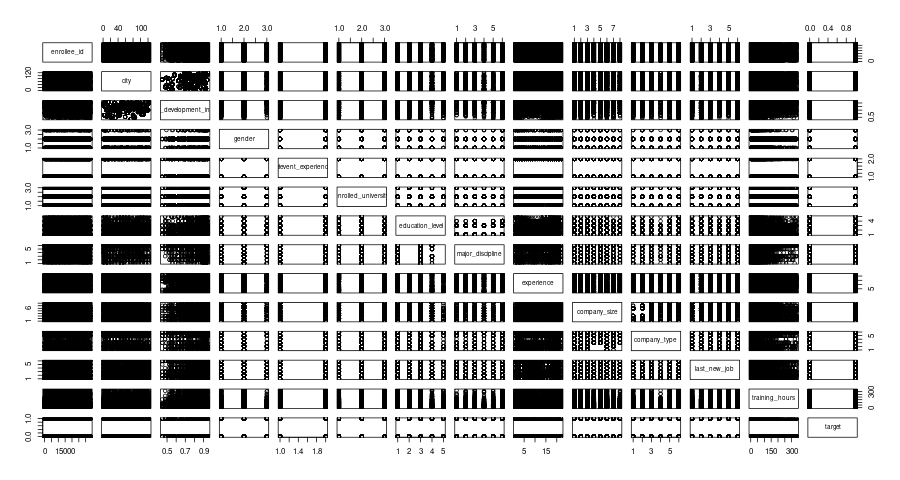

In [ ]:
l = colnames(train)
for(i in 3:ncol(train)){
    if(i %in% c(3,13) ){
        hist(train[ , i],col="#3090C7",main=l[i])
    }
    else{
        barplot(table(train[ , i]),col=rainbow(length(unique(train[ , i]))),main=l[i]) 
    }
}

<h4><font color = 'dark blue'>Filter data according to value of target feature</font></h4>

In [ ]:
change = train[train$target == 1,]# looking for change
no_change = train[train$target == 0,]# not looking for change

In [ ]:
fig <- plot_ly(change, labels = ~relevent_experience,marker = list(colors = c("#3090C7","red")), type = 'pie',domain = list(x = c(0, 0), y = c(1, 1)))
fig <- fig %>% layout(title = 'Percentages of each class of relevent_experience feature when target is looking for job change')

fig

fig2 <- plot_ly(no_change, labels = ~relevent_experience,marker = list(colors = c("red","red")), type = 'pie',domain = list(x = c(0, 0), y = c(1, 1)))
fig2 <- fig2 %>% layout(title = 'Percentages of each class of relevent_experience feature when target is not looking for job change')

fig2

In [ ]:
fig <- plot_ly(change, labels = ~education_level, type = 'pie',domain = list(x = c(0, 0), y = c(1, 1)))
fig <- fig %>% layout(title = 'Percentages of each class of education_level feature when target is looking for job change')

fig

fig2 <- plot_ly(no_change, labels = ~education_level, type = 'pie',domain = list(x = c(0, 0), y = c(1, 1)))
fig2 <- fig2 %>% layout(title = 'Percentages of each class of education_level feature when target is not looking for job change')

fig2

In [ ]:
fig <- plot_ly(change, labels = ~major_discipline, type = 'pie',domain = list(x = c(0, 0), y = c(1, 1)))
fig <- fig %>% layout(title = 'Percentages of each class of major_discipline feature when target is looking for job change')

fig

fig2 <- plot_ly(no_change, labels = ~major_discipline, type = 'pie',domain = list(x = c(0, 0), y = c(1, 1)))
fig2 <- fig2 %>% layout(title = 'Percentages of each class of major_discipline feature when target is not looking for job change')

fig2

In [ ]:
fig <- plot_ly(change, labels = ~gender, type = 'pie',domain = list(x = c(0, 0), y = c(1, 1)))
fig <- fig %>% layout(title = 'Percentages of each class of gender feature when target is looking for job change')

fig

fig2 <- plot_ly(no_change, labels = ~gender, type = 'pie',domain = list(x = c(0, 0), y = c(1, 1)))
fig2 <- fig2 %>% layout(title = 'Percentages of each class of gender feature when target is not looking for job change')

fig2

<h4><font color = 'dark blue'>Print nulls count in each feature</font></h4>

In [ ]:
res<-NULL
for (i in 1:ncol(train)){
  temp<-sum(is.na(train[,i]))
  temp<-as.data.frame(temp)
  temp$percentage<- sum(is.na(train[,i])) * 100 / nrow(train)
  temp$var<-colnames(train)[i]
  res<-rbind(res,temp)
}
res

In [ ]:
res$var <- factor(res$var,levels = res$var[order(res$temp,decreasing = TRUE)])

ggplot(res,aes(x=var,y=temp))+
  geom_bar(stat = "identity",col = "green")+
    theme(axis.text.x = element_text(angle = 90, hjust =1, vjust = 0.5))+
    geom_label(aes(label = temp, size = NULL), nudge_y = 0.7)+
    theme(plot.title = element_text(hjust = 0.5))+
    ggtitle("Total NA's by each col")+
    xlab("Missing Values")
    ylab("Total NA's")

In [ ]:
fig <- plot_ly(res, x = ~var, y = ~percentage, type = 'bar')
fig <- fig %>% layout(title = 'Percentages of nulls in each column')

fig

<h2><font color = 'darkblue'>3. Preprocessing </font></h2>

<h4><font color = 'dark blue'>Plot histograms to check skewness</font></h4>

In [ ]:
#par(mfrow=c(2,2))
hr<-train
hist(hr$city_development_index,col="#3090C7",main="city_development_index")#left skewed
hist(hr$training_hours,col="#3090C7",main="training_hours")#right skewed
hr$training_hours = log(hr$training_hours)
#hr$city_development_index = log(hr$city_development_index)
hist(hr$training_hours,col="green")

<h4><font color = 'dark blue'>Plot pie chart to check balance of target column</font></h4>

In [ ]:
fig <- plot_ly(hr, labels = ~target, type = 'pie')
fig <- fig %>% layout(title = 'Percentages of each value in target column')

fig

<h4><font color = 'dark blue'>Plot boxplots to check outliers </font></h4>

In [ ]:
#visualize the outliers
boxplot(hr$city_development_index,main="city_development_index",col='red')
boxplot(hr$training_hours,main="training_hours",col='red')

<h4><font color = 'dark blue'>Handling outliers without dropping them</font></h4>

In [ ]:
outliers_features = c("city_development_index","training_hours")
for (i in outliers_features) {
  Inter_Quartile_Range <- IQR(hr[[i]])
  lower_boundary <- quantile(hr[[i]], 0.25) - (Inter_Quartile_Range * 1.5)
  upper_boundary <- quantile(hr[[i]], 0.75) + (Inter_Quartile_Range * 1.5)
  hr[[i]] <- ifelse(hr[[i]] > upper_boundary, upper_boundary,
                           ifelse(hr[[i]] < lower_boundary, lower_boundary, hr[[i]]))
}


In [ ]:
#visualize the outliers
boxplot(hr$city_development_index,main="city_development_index",col='red')
boxplot(hr$training_hours,main="training_hours",col='red')#outliers at values above 250

<h4><font color = 'dark blue'>Divide this experience feature to classes</font></h4>

In [ ]:
#experience
unique(hr$experience)
#too many values for experience so let us divide it into sections
hr$experience[hr$experience=="<1"|hr$experience=="1"|hr$experience=="2"|hr$experience=="3"|hr$experience=="4"|hr$experience=="5"]<-"0-5"
hr$experience[hr$experience=="6"|hr$experience=="7"|hr$experience=="8"|hr$experience=="9"|hr$experience=="10"]<-"5-10"
hr$experience[hr$experience=="11"|hr$experience=="12"|hr$experience=="13"|hr$experience=="14"|hr$experience=="15"]<-"10-15"
hr$experience[hr$experience=="16"|hr$experience=="17"|hr$experience=="18"|hr$experience=="19"|hr$experience=="20"|hr$experience==">20"]<-"15-20"
barplot(table(hr$experience),col=rainbow(4),main="experience in intervals")#most people have five years of experience

<h4><font color = 'dark blue'>Drop features enrollee id and city and relevant experience</font></h4>

In [ ]:
hr<-hr[-c(1,2,5)]
names(hr)
#hr<-hr[!is.na(hr$major_discipline)|hr$target==1,]
#hr$major_discipline[hr$major_discipline!="STEM"&hr$major_discipline!="No Major"]<-"Other"
#hr<-hr[!is.na(hr$enrolled_university)|hr$target==1,]
#hr<-hr[!is.na(hr$education_level)|hr$target==1,]
#hr<-hr[!is.na(hr$last_new_job)|hr$target==1,]
#hr<-hr[!is.na(hr$experience)|hr$target==1,]
dim(hr)
head(hr)

<h4><font color = 'dark blue'>Dealing with nulls by predicting them using missRanger library</font></h4>

In [ ]:
new_hr<-missRanger(
  hr,
  formula = . ~ .,
  num.trees=100,
  seed=3
)

In [ ]:
head(new_hr)

In [ ]:
res<-NULL
for (i in 1:ncol(new_hr)){
  temp<-sum(is.na(new_hr[,i]))
  temp<-as.data.frame(temp)
  temp$percentage<- sum(is.na(new_hr[,i])) * 100 / nrow(new_hr)
  temp$var<-colnames(new_hr)[i]
  res<-rbind(res,temp)
}
res

In [ ]:
res$var <- factor(res$var,levels = res$var[order(res$temp,decreasing = TRUE)])

ggplot(res,aes(x=var,y=temp))+
  geom_bar(stat = "identity",col = "green")+
    theme(axis.text.x = element_text(angle = 90, hjust =1, vjust = 0.5))+
    geom_label(aes(label = temp, size = NULL), nudge_y = 0.7)+
    theme(plot.title = element_text(hjust = 0.5))+
    ggtitle("Total NA's by each col")+
    xlab("Missing Values")
    ylab("Total NA's")

<h4><font color = 'dark blue'>As we can't pass strings to the model i used one hot encoder to label categorical features</font></h4>

In [ ]:
categorical_features = new_hr[-c(1,10,11)]

encoding <- build_encoding(new_hr, cols = colnames(categorical_features), verbose = TRUE)

new_hr2 <- one_hot_encoder(new_hr, encoding = encoding, drop = TRUE)
head(new_hr2)

<h4><font color = 'dark blue'>As we can't pass strings to the model i used label encoder to label categorical features</font></h4>

In [ ]:
#Don't forget to draw heatmap after label encoding
# label encoding
#train <- hr
#train$city <- as.factor(train$city)
#train$gender <- as.numeric(factor(train$gender))
#train$relevent_experience <- as.factor(train$relevent_experience)
#train$enrolled_university <- as.numeric(factor(train$enrolled_university))
#train$education_level <- as.numeric(factor(train$education_level))
#train$major_discipline <- as.numeric(factor(train$major_discipline))
#train$experience <- as.numeric(factor(train$experience))
#train$company_size <- as.numeric(factor(train$company_size))
#train$company_type <- as.numeric(factor(train$company_type))
#train$last_new_job <- as.numeric(factor(train$last_new_job))
#train$training_hours <- as.double(train$training_hours)
#train$target <- as.numeric(train$target)

#str(train)
#head(train)


In [ ]:
train = new_hr2

In [ ]:
colnames(train)

In [ ]:
colnames(train)[8] <- 'enrolled.university.Full.time.course'
colnames(train)[9] <- 'enrolled.university.Part.time.course'
colnames(train)[12] <- 'education.level.High.School'
colnames(train)[14] <- 'education.level.Primary.School'
colnames(train)[16] <- 'major.discipline.Business.Degree'
colnames(train)[19] <- 'major.discipline.No.Major'
colnames(train)[33] <- 'company.type.Pvt.Ltd'
colnames(train)[34] <- 'company.type.Funded.Startup'
colnames(train)[35] <- 'company.type.Early.Stage.Startup'
colnames(train)[37] <- 'company.type.Public.Sector'

<h4><font color = 'dark blue'>As we saw that target feature is unbalanced therefore i used oversampler to balance classes in this feature</font></h4>

In [ ]:
new_train <- oversample(train, method = "ADASYN",classAttr = "target")

In [ ]:
table(train$target)
table(new_train$target)

In [ ]:
barplot(table(new_train$target),col=rainbow(2),main="target")

In [ ]:
head(new_train)

In [ ]:
dim(new_train)

<h4><font color = 'dark blue'>Plot visualizations of data after preprocessing</font></h4>

In [ ]:
l = colnames(new_train)
for(i in 1:ncol(new_train)){
    if(i == 1){
        hist(new_train$city_development_index,col="#3090C7",main=l[i])
    }
    if(i == 2){
        hist(new_train$training_hours,col="#3090C7",main=l[i])
    }
    if(i>2){
        barplot(table(new_train[ , ..i]),col=c("red","#3090C7"),main=l[i]) 
    }
}

In [ ]:
#l = colnames(new_train)
#for(i in 2:(ncol(new_train)-2)){
#    new_train[ , i] = round(new_train[ , i],digits =0)
#}
#new_train


<h4><font color = 'dark blue'>Plot correlations heatmap and check correlations with target feature</font></h4>

In [ ]:
ggplotly(ggplot(melt(cor(new_train)),width=100, aes(Var1, Var2, fill=value)) +
  geom_tile() +
  scale_fill_gradient2(low="blue", high="red", mid="white", 
                       midpoint=0, limit=c(-1,1), space="Lab", 
                       name="Correlation") +
geom_text(aes(Var2, Var1, label = value), size = 3)+
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, vjust = 1, 
                                   size = 12, hjust = 1)))

<h4><font color = 'dark blue'>Drop features with low correlation with target</font></h4>

In [ ]:
train <- subset(new_train, select = -c(15, 24, 27, 35,41))
head(train)

<h4><font color = 'dark blue'>Splitting data into X (features) and Y (target column)</font></h4>

In [ ]:
X <- select(train, -target)
y <- train$target

col <- colnames(X)

In [ ]:
dim(X)

<h4><font color = 'dark blue'>Apply normalization on features</font></h4>

In [ ]:
XS = scale(X)

<h4><font color = 'dark blue'>Splitting data to train (80%) and validation (20%)</font></h4>

In [ ]:
set.seed(42)
trainIndex <- createDataPartition(y, p = 0.8, list = FALSE)
x_train <- XS[trainIndex,]
x_val <- XS[-trainIndex,]
y_train <- y[trainIndex]
y_val <- y[-trainIndex]

In [ ]:
dim(x_train)

<h2><font color = 'darkblue'>4. Modeling </font></h2>

In [ ]:
#specify the cross-validation method
ctrl <- trainControl(method = "cv", number = 5)

#fit a regression model and use k-fold CV to evaluate performance
model <- train(target ~., data = train, method = "lm", trControl = ctrl)

#view summary of k-fold CV               
print(model)

In [ ]:
#view predictions for each fold
model$resample

<h4><font color = 'dark blue'>I used XGBoost classifier model to predict whether candidate not looking for job change (0) or looking for a job change (1)</font></h4>

In [ ]:
xgb_train = xgb.DMatrix(data = x_train, label = y_train)
xgb_test = xgb.DMatrix(data = x_val, label = y_val)

In [ ]:
#define watchlist
#watchlist = list(train=xgb_train, test=xgb_test)

#fit XGBoost model and display training and testing data at each round
model = xgb.train(data=xgb_train,nrounds=500, objective = "binary:logistic")

In [ ]:
label = getinfo(xgb_test, "label")
label_train = getinfo(xgb_train,"label")
pred = predict(model, xgb_test)
pred_train = predict(model, xgb_train)
prediction = ifelse (pred > 0.5,1,0)
prediction_train = ifelse (pred_train > 0.5,1,0)
err = as.numeric(sum(prediction != label))/length(label)
err_train = as.numeric(sum(prediction_train != label_train))/length(label_train)

<h2><font color = 'darkblue'>5. Evaluation </font></h2>

<h4><font color = 'dark blue'>Print accuracy and error percentage on train and validation set</font></h4>

In [ ]:
print(paste("test-error=", round(err,digits=2)))
print(paste("Accuracy on validation set", round(Accuracy(prediction, y_val)*100,digits=0),"%"))

<h4><font color = 'dark blue'>Plot confusion matrix with f1 score, precision, recall and accuracy</font></h4>

In [ ]:
cm = confusionMatrix(as.factor(prediction), as.factor(y_val))

draw_confusion_matrix <- function(cm) {
  
  layout(matrix(c(1,1,2)))
  par(mar=c(2,2,2,2))
  plot(c(100, 345), c(300, 450), type = "n", xlab="", ylab="", xaxt='n', yaxt='n')
  title('CONFUSION MATRIX', cex.main=2)
  
  rect(150, 430, 240, 370, col='skyblue')
  text(195, 435, 'Not looking for a job', cex=1.2)
  rect(250, 430, 340, 370, col='tomato')
  text(295, 435, 'Looking for a job', cex=1.2)
  text(125, 370, 'Prediction', cex=1.3, srt=90, font=2)
  text(245, 450, 'Reality', cex=1.3, font=2)
  rect(150, 305, 240, 365, col='tomato')
  rect(250, 305, 340, 365, col='skyblue')
  text(140, 400, 'Not looking for a job', cex=1.2, srt=90)
  text(140, 335, 'Looking for a job', cex=1.2, srt=90)
  
  res <- as.numeric(cm$table)
  text(195, 400, res[1], cex=1.6, font=2, col='white')
  text(195, 335, res[2], cex=1.6, font=2, col='white')
  text(295, 400, res[3], cex=1.6, font=2, col='white')
  text(295, 335, res[4], cex=1.6, font=2, col='white')
  
  plot(c(100, 0), c(100, 0), type = "n", xlab="", ylab="", main = "DETAILS", xaxt='n', yaxt='n')
  text(10, 85, names(cm$byClass[1]), cex=1.2, font=2)
  text(10, 70, round(as.numeric(cm$byClass[1]), 3), cex=1.2)
  text(30, 85, names(cm$byClass[2]), cex=1.2, font=2)
  text(30, 70, round(as.numeric(cm$byClass[2]), 3), cex=1.2)
  text(50, 85, names(cm$byClass[5]), cex=1.2, font=2)
  text(50, 70, round(as.numeric(cm$byClass[5]), 3), cex=1.2)
  text(70, 85, names(cm$byClass[6]), cex=1.2, font=2)
  text(70, 70, round(as.numeric(cm$byClass[6]), 3), cex=1.2)
  text(90, 85, names(cm$byClass[7]), cex=1.2, font=2)
  text(90, 70, round(as.numeric(cm$byClass[7]), 3), cex=1.2)
  
  text(30, 35, names(cm$overall[1]), cex=1.5, font=2)
  text(30, 20, round(as.numeric(cm$overall[1]), 3), cex=1.4)
  text(70, 35, names(cm$overall[2]), cex=1.5, font=2)
  text(70, 20, round(as.numeric(cm$overall[2]), 3), cex=1.4)
}  

draw_confusion_matrix(cm)


<h1><b><font color = 'dark blue'>Thank you and Good luck </font></b></h1>